# CSC 792 Assignment 8 - Exploring Concept Vectors
## Hunter Paxton and Mangesh Sakordekar

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, pathlib, shutil, random
from PIL import Image

Classes and Functions

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [3]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Encode and Decoder for a 1D Latent Space

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 1

# Adjust the input shape for 64x64 images
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# Now the shape is 4x4x64
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder1d = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder1d")


In [6]:
encoder1d.summary()

Model: "encoder1d"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 8)            80        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 16)           1168      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 8, 8, 32)             4640      ['conv2d_1[0][0]']            
                                                                                          

In [7]:
# Latent input
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
# The shape is now 64x64x8
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder1d = keras.Model(latent_inputs, decoder_outputs, name="decoder1d")

In [8]:
decoder1d.summary()

Model: "decoder1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2048      
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 64)          36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 16)        46

Upload the data folder to google drive as a zip and then unzip the folder to extract the data

In [ ]:
#!unzip ./rotated_data.zip

In [9]:
dirs = os.listdir("./rotated_data")
data = []

for file in dirs:

    # Read the image file
    im = plt.imread("./rotated_data/" + file, format='jpeg')
    #plt.imshow(im, cmap='gray')
    gray_im = rgb2gray(im)[56:428, 142:514]
    img = Image.fromarray(np.uint8(gray_im))
    img_resized = img.resize((64, 64))
    img_resized_array = np.array(img_resized) / 255.0
    img_resized_array = img_resized_array.reshape(64, 64, 1)
    data.append(img_resized_array)

# Convert list to NumPy array for training
data = np.array(data)

In [10]:
vae1d = VAE(encoder1d, decoder1d)
vae1d.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae1d.fit(data, epochs=150, batch_size=32)

Epoch 1/150


32/32 [==============================] - 8s 81ms/step - total_loss: 2240.8916 - reconstruction_loss: 2198.1536 - kl_loss: 43.7210
Epoch 2/150
32/32 [==============================] - 3s 89ms/step - total_loss: 1286.5343 - reconstruction_loss: 1286.4121 - kl_loss: 0.1249
Epoch 3/150
32/32 [==============================] - 2s 69ms/step - total_loss: 1147.7758 - reconstruction_loss: 1147.7371 - kl_loss: 0.0365
Epoch 4/150
32/32 [==============================] - 2s 65ms/step - total_loss: 1113.9751 - reconstruction_loss: 1112.9740 - kl_loss: 0.9532
Epoch 5/150
32/32 [==============================] - 2s 64ms/step - total_loss: 985.5673 - reconstruction_loss: 982.6602 - kl_loss: 2.9025
Epoch 6/150
32/32 [==============================] - 2s 67ms/step - total_loss: 853.4780 - reconstruction_loss: 849.8925 - kl_loss: 3.5527
Epoch 7/150
32/32 [==============================] - 2s 69ms/step - total_loss: 783.9113 - reconstruction_loss: 779.5430 - kl_loss: 4.3433
Epoch 8/150
32/32 [===========

(1,)
1/1 [==============================] - 0s 31ms/step

(1,)
1/1 [==============================] - 0s 27ms/step

(1,)
1/1 [==============================] - 0s 35ms/step

(1,)
1/1 [==============================] - 0s 24ms/step

(1,)
1/1 [==============================] - 0s 18ms/step

(1,)
1/1 [==============================] - 0s 15ms/step

(1,)
1/1 [==============================] - 0s 18ms/step

(1,)
1/1 [==============================] - 0s 16ms/step

(1,)
1/1 [==============================] - 0s 15ms/step

(1,)
1/1 [==============================] - 0s 28ms/step

(1,)
1/1 [==============================] - 0s 16ms/step

(1,)
1/1 [==============================] - 0s 16ms/step

(1,)
1/1 [==============================] - 0s 16ms/step

(1,)
1/1 [==============================] - 0s 16ms/step

(1,)
1/1 [==============================] - 0s 19ms/step

(1,)
1/1 [==============================] - 0s 18ms/step

(1,)
1/1 [==============================] - 0s 23ms/step

(1,)
1/1 [====

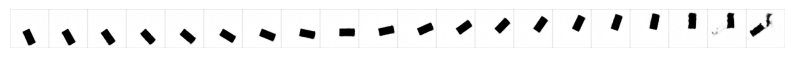

In [16]:
import numpy as np
import matplotlib.pyplot as plt

n = 20  # Number of images to generate
digit_size = 28  # Size of each digit in the final image
l, b = 64, 64  # Size of each generated image
figure = np.zeros((l, b * n))  # Adjusted for a 1D layout

# Generate a 1D grid of points in the latent space
grid_x = np.linspace(-1, 1, n)

for i, xi in enumerate(grid_x):
    z_sample = np.array([xi])  # Ensure z_sample has the correct shape
    print(z_sample.shape)
    x_decoded = decoder1d.predict(z_sample)
    print()
    digit = x_decoded[0].reshape(l, b)
    figure[:, i * b: (i + 1) * b] = digit  # Place horizontally

plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
start_range = b // 2
end_range = n * b + start_range
pixel_range = np.arange(start_range, end_range, b)
sample_range_x = np.round(grid_x, 1)
plt.xticks(pixel_range, sample_range_x)
plt.xlabel("z[0]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")
plt.show()


Code for a 2D latent Space

In [ ]:
#!unzip ./scaled_rotated_data.zip

In [17]:
dirs = os.listdir("./scaled_rotated_data")
data = []

for file in dirs:

    # Read the image file
    im = plt.imread("./scaled_rotated_data/" + file, format='jpeg')
    #plt.imshow(im, cmap='gray')
    gray_im = rgb2gray(im)[56:428, 142:514]
    img = Image.fromarray(np.uint8(gray_im))
    img_resized = img.resize((64, 64))
    img_resized_array = np.array(img_resized) / 255.0
    img_resized_array = img_resized_array.reshape(64, 64, 1)
    data.append(img_resized_array)

# Convert list to NumPy array for training
data = np.array(data)

In [18]:
latent_dim = 2

# Encoder
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# Now the shape is 4x4x64
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder2d = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder2d")

In [19]:
encoder2d.summary()

Model: "encoder2d"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 32, 8)            80        ['input_3[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 16, 16)           1168      ['conv2d_5[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 8, 8, 32)             4640      ['conv2d_6[0][0]']            
                                                                                          

In [20]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
# The shape is now 256x256x32
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder2d = keras.Model(latent_inputs, decoder_outputs, name="decoder2d")

In [21]:
decoder2d.summary()

Model: "decoder2d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              3072      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 8, 8, 64)          36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 16, 16, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 32, 32, 16)        46

In [22]:
vae2d = VAE(encoder2d, decoder2d)
vae2d.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
history = vae2d.fit(data, epochs=150, batch_size=32)

Epoch 1/150
32/32 [==============================] - 5s 68ms/step - total_loss: 2547.6792 - reconstruction_loss: 2543.2744 - kl_loss: 2.2219
Epoch 2/150
32/32 [==============================] - 2s 74ms/step - total_loss: 925.3995 - reconstruction_loss: 918.9733 - kl_loss: 6.5626
Epoch 3/150
32/32 [==============================] - 3s 88ms/step - total_loss: 701.0252 - reconstruction_loss: 699.9791 - kl_loss: 1.0477
Epoch 4/150
32/32 [==============================] - 2s 66ms/step - total_loss: 677.3397 - reconstruction_loss: 676.4634 - kl_loss: 0.8775
Epoch 5/150
32/32 [==============================] - 3s 84ms/step - total_loss: 659.2554 - reconstruction_loss: 658.3503 - kl_loss: 0.9052
Epoch 6/150
32/32 [==============================] - 2s 74ms/step - total_loss: 656.6564 - reconstruction_loss: 655.5176 - kl_loss: 1.1446
Epoch 7/150
32/32 [==============================] - 2s 65ms/step - total_loss: 655.3806 - reconstruction_loss: 654.4948 - kl_loss: 0.8802
Epoch 8/150
32/32 [======

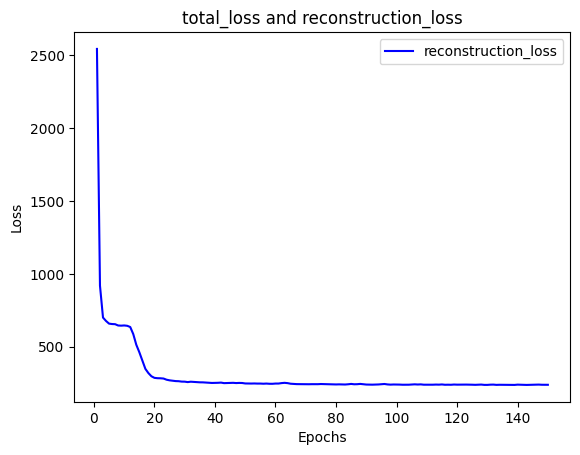

In [23]:
# Extract loss values
# train_loss = history.history['total_loss']
val_loss = history.history['reconstruction_loss']
epochs = range(1, len(val_loss) + 1)

# Plotting
plt.figure()
# plt.plot(epochs, train_loss, 'bo', label='total_loss loss')
plt.plot(epochs, val_loss, 'b', label='reconstruction_loss')
plt.title('total_loss and reconstruction_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
import matplotlib.pyplot as plt

n = 30
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae2d.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

1/1 [==============================] - 0s 19ms/step


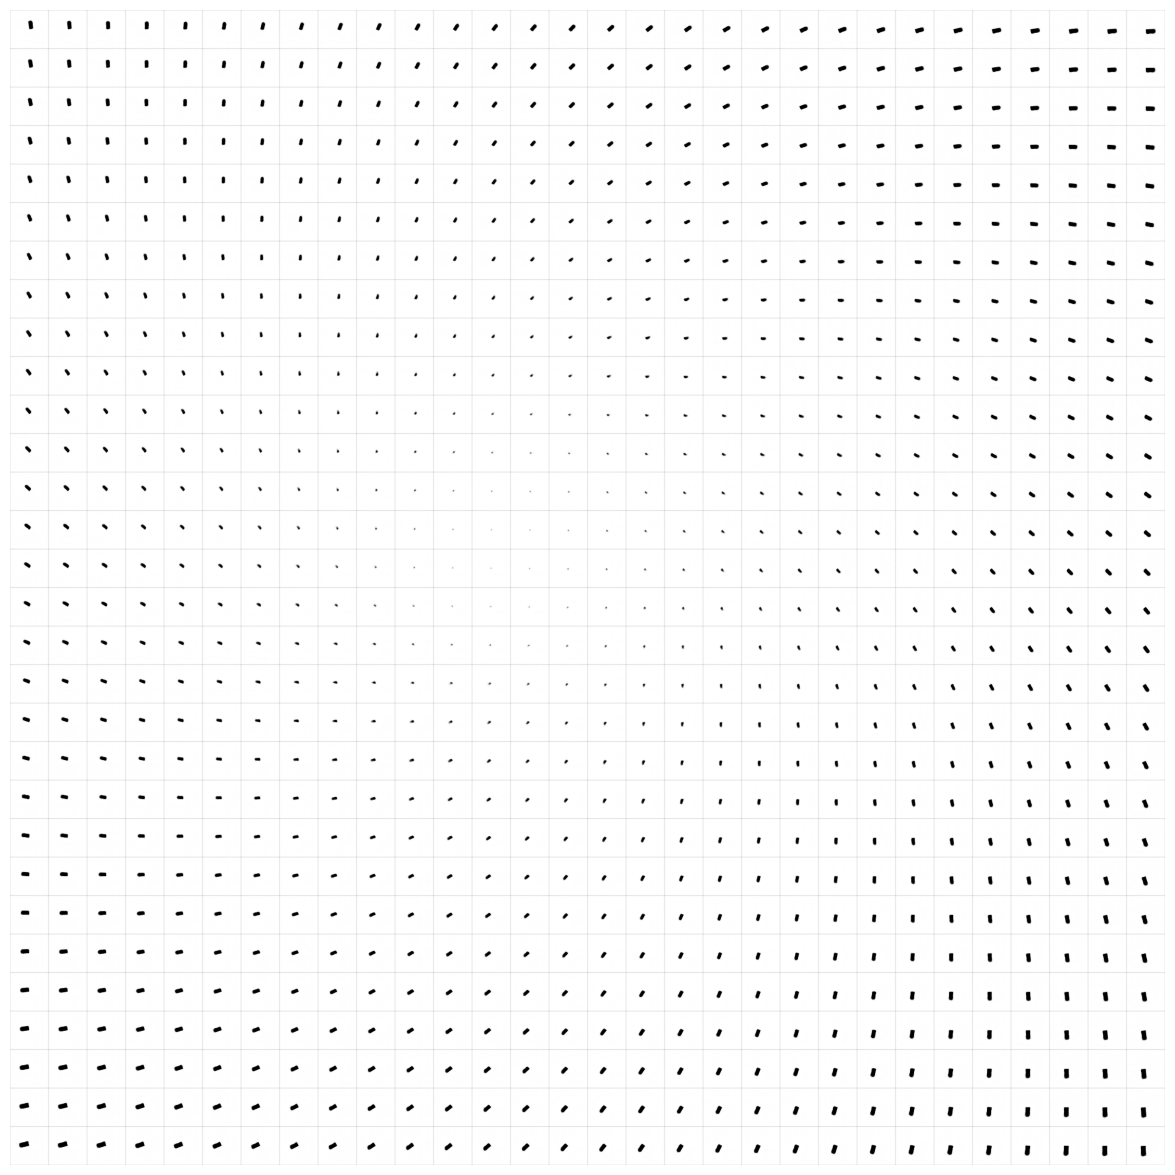

In [26]:
plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")